# Symbolic Neural Network Training

This notebook demonstrates building and training a neural network using symbolic differentiation with sympy.

## Network Structure
- 2 inputs
- 2 outputs
- 2 hidden layers
- 4 neurons per hidden layer
- Fully connected

In [1]:
import numpy as np
import sys

from lib import (
    Net, NetConfig, SymbolicActivation, SymbolicLoss, WeightInit,
    CheckpointConfig, compute_data_hash,

)

In [2]:
# Generate training data
np.random.seed(42)

# Random inputs
q1 = np.random.uniform(-1, 1, 1000)
q2 = np.random.uniform(-1, 1, 1000)

# Target function (linear transformation)
def target_function(q1, q2):
    X1 = q1 + q2 - 1
    X2 = q1 - q2 + 1
    return X1, X2

X1, X2 = target_function(q1, q2)

# Prepare training data
inputs = [[q1[i], q2[i]] for i in range(len(q1))]
targets = [[X1[i], X2[i]] for i in range(len(X1))]

# Convert to numpy arrays
inputs = np.array(inputs)
targets = np.array(targets)

print(f"Generated {len(inputs)} training samples")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

Generated 1000 training samples
Input shape: (1000, 2)
Target shape: (1000, 2)


## Create the Network

In [3]:
config = NetConfig(
    n_inputs=2,
    n_outputs=2,
    n_hidden_layers=2,
    n_neurons_per_hidden=4,
    hidden_activation=SymbolicActivation.relu(),
    output_activation=SymbolicActivation.linear(),
    loss_func=SymbolicLoss.mse(),
    weight_init=WeightInit.XAVIER,
    bias_init_std=0.01,
    seed=42
)

net = Net.fully_connected(config)

print(f"Created network with {len(net.layers)} layers")
print(f"Layer sizes: {[len(layer.neurons) for layer in net.layers]}")
print(f"First layer: {len(net.layers[0].neurons)} neurons, {len(net.layers[0].neurons[0].connections)} inputs each")

Created network with 3 layers
Layer sizes: [4, 4, 2]
First layer: 4 neurons, 2 inputs each


## Train the Network

In [4]:
# Convert inputs to list of arrays for the train method
input_list = [inputs[i] for i in range(len(inputs))]
target_list = [targets[i] for i in range(len(targets))]

print("Training...")
result = net.train(
    inputs=input_list,
    targets=target_list,
    learning_rate=0.01,
    epochs=1000,
    batch_size=32
)

print(f"Training complete!")
print(f"Final loss: {result['loss_history'][-1]:.6f}")

Training...
Training complete!
Final loss: 0.000003


## Loss History

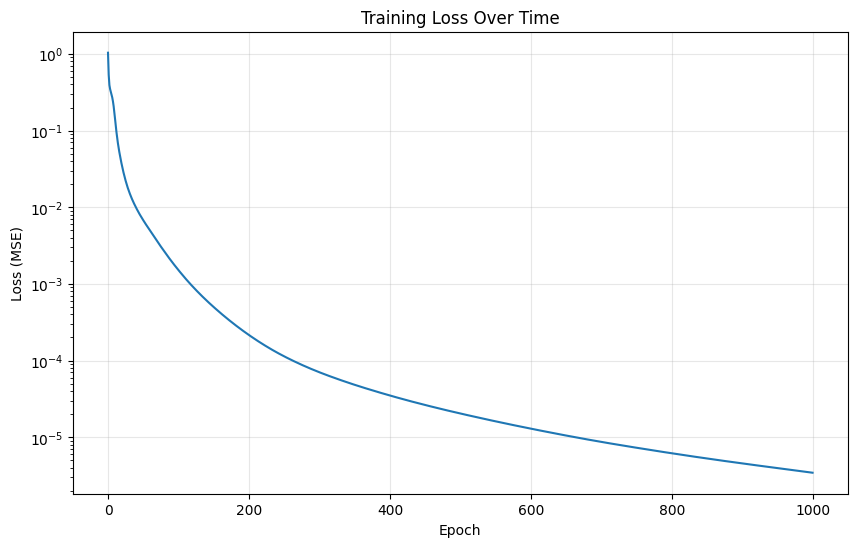

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(result['loss_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Test Trained Network

## Checkpointing and Caching

The training supports checkpointing to save network state during training and resume from checkpoints.

In [6]:
# Create a new network for checkpointing demo
net_checkpoint = Net.fully_connected(NetConfig(
    n_inputs=2,
    n_outputs=2,
    n_hidden_layers=2,
    n_neurons_per_hidden=4,
    hidden_activation=SymbolicActivation.relu(),
    output_activation=SymbolicActivation.linear(),
    loss_func=SymbolicLoss.mse(),
    seed=42
))

# Compute hash for training data
data_hash = compute_data_hash(input_list, target_list)
print(f"Data hash: {data_hash}")

# Configure checkpointing
checkpoint_config = CheckpointConfig(
    enabled=True,
    cache_dir='.net_cache',
    checkpoint_interval=20,
    data_hash=data_hash,
    overwrite=False  # Set to True to ignore existing cache
)

# Train with checkpointing
print("Training with checkpointing...")
result_checkpoint = net_checkpoint.train(
    inputs=input_list,
    targets=target_list,
    learning_rate=0.01,
    epochs=60,
    batch_size=32,
    checkpoint_config=checkpoint_config
)

print(f"Training complete. Final loss: {result_checkpoint['loss_history'][-1]:.6f}")

Data hash: 142ce5043863f801
Training with checkpointing...
Loaded checkpoint from epoch 100, returning first 60 epochs of loss history.
Training complete. Final loss: 0.005105


In [7]:
# Resume training from checkpoint
print("Resuming training from checkpoint...")
result_resume = net_checkpoint.train(
    inputs=input_list,
    targets=target_list,
    learning_rate=0.01,
    epochs=100,
    batch_size=32,
    checkpoint_config=checkpoint_config
)

print(f"Resumed training complete. Final loss: {result_resume['loss_history'][-1]:.6f}")

Resuming training from checkpoint...
Loaded checkpoint from epoch 100, returning first 100 epochs of loss history.
Resumed training complete. Final loss: 0.001119


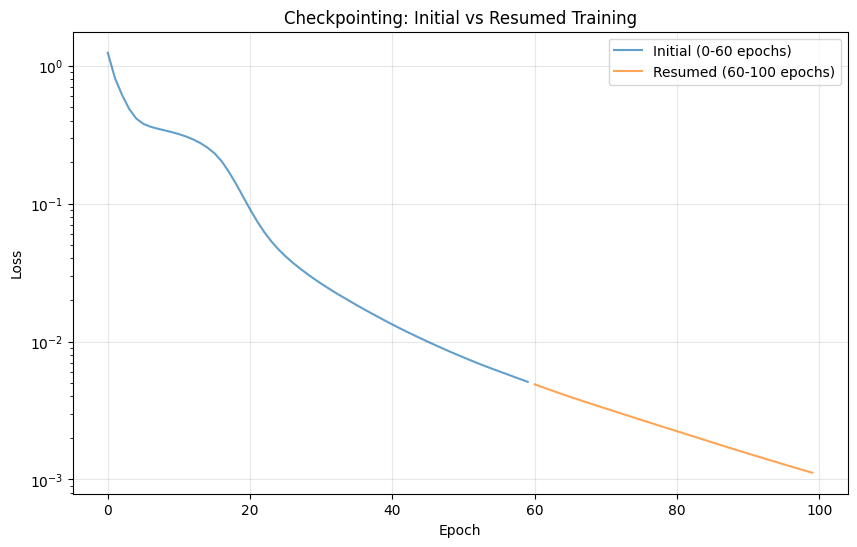

In [8]:
# Compare original and resumed training
plt.figure(figsize=(10, 6))
plt.plot(result_checkpoint['loss_history'], label='Initial (0-60 epochs)', alpha=0.7)
plt.plot(range(60, 100), result_resume['loss_history'][60:], label='Resumed (60-100 epochs)', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Checkpointing: Initial vs Resumed Training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

In [9]:
# Test on a few examples
test_inputs = np.array([[0.5, 0.3], [-0.5, 0.8], [0.0, 0.0], [0.7, -0.2]])

for test_input in test_inputs:
    activations, _ = net.forward(test_input)
    predicted = activations[-1]
    expected = np.array(target_function(test_input[0], test_input[1]))
    
    print(f"Input: [{test_input[0]:.2f}, {test_input[1]:.2f}]")
    print(f"  Predicted: [{predicted[0]:.4f}, {predicted[1]:.4f}]")
    print(f"  Expected:  [{expected[0]:.4f}, {expected[1]:.4f}]")
    print(f"  Error:     [{abs(predicted[0]-expected[0]):.4f}, {abs(predicted[1]-expected[1]):.4f}]")
    print()

Input: [0.50, 0.30]
  Predicted: [-0.1995, 1.1999]
  Expected:  [-0.2000, 1.2000]
  Error:     [0.0005, 0.0001]

Input: [-0.50, 0.80]
  Predicted: [-0.7002, -0.3000]
  Expected:  [-0.7000, -0.3000]
  Error:     [0.0002, 0.0000]

Input: [0.00, 0.00]
  Predicted: [-0.9998, 0.9998]
  Expected:  [-1.0000, 1.0000]
  Error:     [0.0002, 0.0002]

Input: [0.70, -0.20]
  Predicted: [-0.4999, 1.8999]
  Expected:  [-0.5000, 1.9000]
  Error:     [0.0001, 0.0001]



## Error Surface Visualization

In [10]:
import plotly.graph_objects as go

# Create a grid over the input space
grid_size = 50
q1_range = np.linspace(-1, 1, grid_size)
q2_range = np.linspace(-1, 1, grid_size)
Q1_grid, Q2_grid = np.meshgrid(q1_range, q2_range)

# Calculate error at each point
error_grid = np.zeros_like(Q1_grid)

for i in range(grid_size):
    for j in range(grid_size):
        test_input = np.array([Q1_grid[i, j], Q2_grid[i, j]])
        activations, _ = net.forward(test_input)
        predicted = activations[-1]
        expected = np.array(target_function(test_input[0], test_input[1]))
        error = np.sum((predicted - expected)**2)
        error_grid[i, j] = error

# Create interactive 3D plot
fig = go.Figure(data=[go.Surface(
    x=Q1_grid,
    y=Q2_grid,
    z=error_grid,
    colorscale='Viridis',
    colorbar=dict(title='Error')
)])

fig.update_layout(
    title='Network Error Over Input Space',
    scene=dict(
        xaxis_title='q1',
        yaxis_title='q2',
        zaxis_title='Error'
    ),
    width=800,
    height=700
)

fig.show()

print(f"Max error: {np.max(error_grid):.6f}")
print(f"Mean error: {np.mean(error_grid):.6f}")

Max error: 0.020017
Mean error: 0.000027


## Custom Loss Functions

You can define custom symbolic loss functions. Some loss functions (like those using `Abs` or `Piecewise`) don't vectorize well for batch processing. These have `supports_batch=False` and will automatically fall back to sample-by-sample training.

In [11]:
# Mean Absolute Error loss - uses symbolic Abs which doesn't batch well
# The training will automatically fall back to sample-by-sample processing
mae_loss = SymbolicLoss.mae()

print(f"Loss: {mae_loss.name}")
print(f"Expression: {mae_loss.expression}")
print(f"Gradient: {mae_loss.gradient}")
print(f"Supports batch: {mae_loss.supports_batch}")

net_mae = Net.fully_connected(NetConfig(
    n_inputs=2,
    n_outputs=2,
    n_hidden_layers=2,
    n_neurons_per_hidden=4,
    hidden_activation=SymbolicActivation.relu(),
    output_activation=SymbolicActivation.linear(),
    loss_func=mae_loss,
    seed=42
))

print("\nTraining with MAE loss (falls back to sample-by-sample)...")
result_mae = net_mae.train(
    inputs=input_list,
    targets=target_list,
    learning_rate=0.01,
    epochs=100,
    batch_size=32  # This is ignored since MAE doesn't support batch
)

print(f"Final loss: {result_mae['loss_history'][-1]:.6f}")

Loss: mae
Expression: Abs(y_pred - y_true)
Gradient: sign(y_pred - y_true)
Supports batch: False

Training with MAE loss (falls back to sample-by-sample)...
Final loss: 0.048191


### Huber Loss (Piecewise Function)

Huber loss uses a piecewise expression - quadratic for small errors, linear for large errors. Like MAE, it has `supports_batch=False`.

In [12]:
# Huber loss - uses piecewise expression
huber_loss = SymbolicLoss.huber(delta=1.0)

print(f"Loss: {huber_loss.name}")
print(f"Expression: {huber_loss.expression}")
print(f"Gradient: {huber_loss.gradient}")
print(f"Supports batch: {huber_loss.supports_batch}")

net_huber = Net.fully_connected(NetConfig(
    n_inputs=2,
    n_outputs=2,
    n_hidden_layers=2,
    n_neurons_per_hidden=4,
    hidden_activation=SymbolicActivation.relu(),
    output_activation=SymbolicActivation.linear(),
    loss_func=huber_loss,
    seed=42
))

print("\nTraining with Huber loss (falls back to sample-by-sample)...")
result_huber = net_huber.train(
    inputs=input_list,
    targets=target_list,
    learning_rate=0.01,
    epochs=100,
    batch_size=32  # This is ignored since Huber doesn't support batch
)

print(f"Final loss: {result_huber['loss_history'][-1]:.6f}")

Loss: huber
Expression: Piecewise(((y_pred - y_true)**2/2, Abs(y_pred - y_true) <= 1.0), (1.0*Abs(y_pred - y_true) - 0.5, True))
Gradient: Piecewise((y_pred - y_true, Abs(y_pred - y_true) <= 1.0), (Piecewise((0, Eq(y_pred, y_true)), (1.0*(y_pred - y_true)/Abs(y_pred - y_true), True)), True))
Supports batch: False

Training with Huber loss (falls back to sample-by-sample)...
Final loss: 0.000000


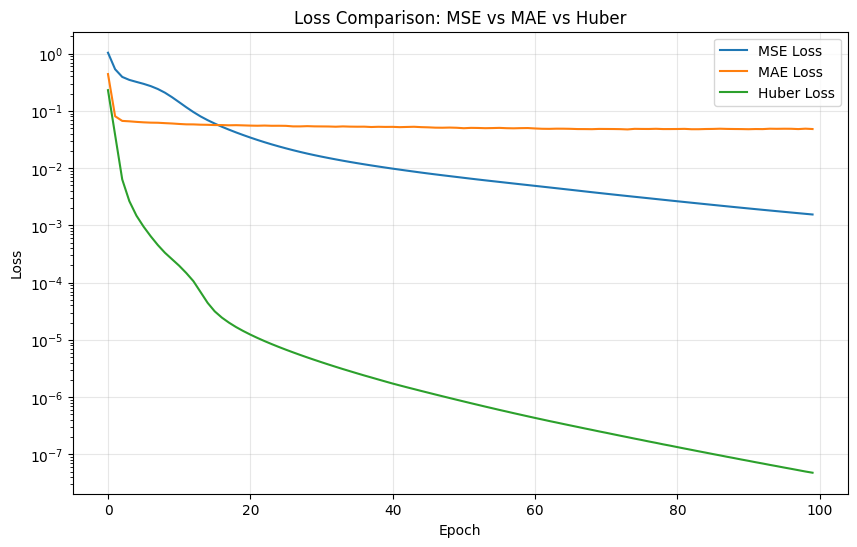

In [13]:
# Compare loss curves for different loss functions
plt.figure(figsize=(10, 6))
plt.plot(result['loss_history'][:100], label='MSE Loss')
plt.plot(result_mae['loss_history'], label='MAE Loss')
plt.plot(result_huber['loss_history'], label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: MSE vs MAE vs Huber')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()